Project on sentiment analysis which is a NLP based project using python as the language using packages such as tensorflow.

In [0]:
#We are using gpu, To know more about the hardware we are using
!nvidia-smi

Fri May  1 21:12:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#Mounting Google drive so as to access data from the drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Copying data from folder DATA_ASSIGN7 to local
!cp /content/drive/My\ Drive/DATA_ASSIGN7/*.csv ./

In [0]:
#library pandas for data manipulation and analysis
#import large sentiment analysis tweet dataset
import pandas as pd
df = pd.read_csv('cleaned_tweets_1point6_million.csv')
df.dropna(inplace=True) # removing na or empty places from the dataset
df.head() #taking only the  heads or heading of the tweets


,labels,tweets
0,0,switchfoot httptwitpiccomyzl awww that bummer ...
1,0,upset cant updat facebook text might cri resul...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav im mad cant see


In [0]:
#See our unique labels
df.labels.unique()

array([0, 4])

In [0]:
df[df.labels == 0].head() 

,labels,tweets
0,0,switchfoot httptwitpiccomyzl awww that bummer ...
1,0,upset cant updat facebook text might cri resul...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav im mad cant see


In [0]:
df[df.labels == 4].head()

,labels,tweets
719642,4,love healthuandpet u guy r best
719643,4,im meet one besti tonight cant wait girl talk
719644,4,darealsunisakim thank twitter add sunisa got m...
719645,4,sick realli cheap hurt much eat real food plu ...
719646,4,lovesbrooklyn effect everyon


In [0]:
# Above can be seen that 
#0 encodes negative sentiment 
#4 encodes positive sentiment

In [0]:
#Using the data to train our model

In [0]:
#More non usuable sentiments are also there as in like 2 for none or neutral sentiments 
#so even though this is cleaned dataset further cleaing is required
#converting above labels to 0 and 1

# Preprcessing tweets dataset

df.labels = df.labels.apply(lambda x:int(x==4))# converting labels encoding 0-4 to 0-1 by representing 4 as 1,int(x==4) returns 1 if x==4 else 0
df.tweets = df.tweets.apply(lambda x:x.strip())#remove empty spaces from start and ending of tweets
df = df[~(df.tweets =='')]#remove empty tweets

In [0]:
#Huge dataset check the length of dataset
len(df)

1439658

In [0]:
# Working only in sample (i.e, 50% of the entire data)
sample = df.sample(int(0.5*len(df)))#multiply by 0.9 means 90% similarly 1.0 means 100% and 0.01 means 1%

In [0]:
#use tensorflow to train our LSTM network
# First we need data loader

import tensorflow as tf
datagen = tf.data.Dataset.from_tensor_slices((sample.tweets,sample.labels))
# datagen is a generator
# while in the looop generates lists

In [0]:
# How this generator works
# here we use a iter datatype (creates object which can iterate one element at a time)
tweets, labels = next(iter(datagen))

In [0]:
#if we look at the data structure now 
tweets

<tf.Tensor: shape=(), dtype=string, numpy=b'fuck homework im go write that waaaay better'>

In [0]:
#for labels 
labels

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [0]:
#Now the library understants the data

In [0]:
# We will use tokenizer to create tokens
import tensorflow_datasets as tfds

# Let us create a tokenizer
tokenizer = tfds.features.text.Tokenizer()
vocabulary_set = set()
for text_tensor in sample.tweets.values:
  some_tokens = tokenizer.tokenize(text_tensor)
  vocabulary_set.update(some_tokens)

In [0]:
#But now we need a dictionary to map every word with the numbers
#So an encoder

In [0]:
# Now we will create our encoder
# This encoder will encode text to numbers
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [0]:
#To check unique words 
encoder.vocab_size

415468

In [0]:
# Let us see encoder in action
sampletweet = sample.tweets.values[0]
encodedtweet = encoder.encode(sample.tweets.values[0])
decodedtweet = encoder.decode(encodedtweet)
print(f'sample tweet : \n{sampletweet}')
print(f'encode tweet : \n{encodedtweet}')
print(f'decode tweet : \n{decodedtweet}')

sample tweet : 
fuck homework im go write that waaaay better
encode tweet : 
[267552, 68900, 371284, 341992, 283341, 114529, 212346, 356209]
decode tweet : 
fuck homework im go write that waaaay better


In [0]:
 #encode.decode([384896, 402755, 185880])
 #Problem of converting word to number or number to word solved

In [0]:
#Problem different tweets has different word size(like some tweets have 13 words or only 7words) 
#but what we are providing is an array i.e. the words must be same while providing 
#so we must create a method that converts it into a vector such that if it is 7words it'll be filled with 0's to make it till 13element vector


In [0]:
# Our sample size
N = len(sample)

In [0]:
# To encode our text data to number which are indices in embedding matrix

# Need of these function
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

def encode_map_fn(text, label): 
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

  # `tf.data.Datasets` works best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label



# Now let us map datagenerator to encode_map_fn
sample_map = datagen.map(encode_map_fn)


# Now we will break our sample_map to train and test (90% and 10%)
train_data = sample_map.skip(int(N * 0.9))
train_data = train_data.padded_batch(50, padded_shapes=([None],[]))

test_data = sample_map.take(int(N * 0.1))
test_data = test_data.padded_batch(50, padded_shapes=([None],[]))

In [0]:
#check
train_samplex, train_sampley = next(iter(train_data))

In [0]:
# we have 50 tweets having 18 features(i.e, words)
#we have taken batch size 50
train_samplex.shape

TensorShape([50, 18])

In [0]:
#We can take many data and train it making the model faster and better working
train_sampley.shape

TensorShape([50])

In [0]:
# Problem making the model

In [0]:
# Creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size,output_dim=64), #convert given datasent to vector like dictionary maps the word
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
model(train_samplex).shape #prediction 

TensorShape([50, 1])

In [0]:
#model detail

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          26589952  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [0]:
#comipling the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
# training the model
history = model.fit(train_data, 
                    epochs=3, #number of times the data is trained
                    validation_data=test_data
                   )

Epoch 1/3
1440/1440 [==============================] - 384s 267ms/step - loss: 0.5682 - accuracy: 0.6768 - val_loss: 0.5085 - val_accuracy: 0.7422
Epoch 2/3
1440/1440 [==============================] - 382s 265ms/step - loss: 0.4412 - accuracy: 0.7926 - val_loss: 0.5185 - val_accuracy: 0.7408
Epoch 3/3
1440/1440 [==============================] - 383s 266ms/step - loss: 0.3535 - accuracy: 0.8469 - val_loss: 0.6041 - val_accuracy: 0.7194


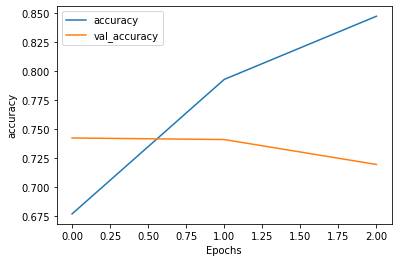

In [0]:
#plotting the results and observations

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy')

In [0]:
# Now let us use covid19 dataset

# Our tweets may have some emoji
# The following function will remove those emojis
def Emoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# Make our data cleaner
corona = pd.read_csv('corona_march15_2020_tweets.csv')
corona = corona[~corona.text.isnull()]
corona = corona[['created_at', 'text', 'country_code', 'place_full_name', 'place_type']]
corona.text = corona.text.apply(lambda x:Emoji(x))
corona.text = corona.text.apply(lambda x:x.strip())
corona = corona[~(corona.text=='')]

In [0]:
corona.head()

,created_at,text,country_code,place_full_name,place_type
0,2020-03-15T00:00:00Z,premier jjhorgan say covid respons nonpartisan...,NaN,NaN,NaN
1,2020-03-15T00:00:00Z,bsp urg public use digit bank covid precaut ht...,NaN,NaN,NaN
2,2020-03-15T00:00:00Z,oratio imperata novel coronaviru covid httpstc...,NaN,NaN,NaN
3,2020-03-15T00:00:00Z,appl shut store outsid china curb coronaviru s...,NaN,NaN,NaN
4,2020-03-15T00:00:00Z,countri around world saturday continu close bo...,NaN,NaN,NaN


In [0]:
# Taking tweets only in us
# We will only keep tweets that have the country code country_code='US' and place_type='city'
us_tweets = corona[corona['country_code'].isin(['US']) ]
us_tweets = us_tweets[us_tweets['place_type'].isin(['city']) ]
us_tweets.head()

,created_at,text,country_code,place_full_name,place_type
61,2020-03-15T00:00:18Z,given feel surprisingli fine iv decid batch co...,US,"Brooklyn, NY",city
67,2020-03-15T00:00:21Z,good thread read understand social distanc nex...,US,"Pawtucket, RI",city
79,2020-03-15T00:00:26Z,amaz credit commun support health worker covid...,US,"Mercer Island, WA",city
188,2020-03-15T00:01:29Z,friend franc suppos fli home day flight cancel...,US,"Brooklyn, NY",city
230,2020-03-15T00:01:55Z,view today entir covid updat ncgovernor health...,US,"Brevard, NC",city


In [0]:
# creating a dataset
coronagen = tf.data.Dataset.from_tensor_slices((us_tweets.text, us_tweets.index))

In [0]:
# mapping like before to convert data into vector
pred_data = coronagen.map(encode_map_fn).padded_batch(50, padded_shapes=([None],[]))

In [0]:
#get our first batch of pred_data which is mapped
samplemap, _ = next(iter(pred_data))
samplemap

<tf.Tensor: shape=(50, 32), dtype=int64, numpy=
array([[102263, 299625, 329420, ...,      0,      0,      0],
       [378414, 199405, 218527, ...,      0,      0,      0],
       [401647,  18176, 283257, ...,      0,      0,      0],
       ...,
       [302370, 267552, 201651, ...,      0,      0,      0],
       [415467, 123110, 415467, ...,      0,      0,      0],
       [415467, 415467, 415467, ...,      0,      0,      0]])>

In [0]:
#seen above 50 data with 32 each coloumns

In [0]:
#will use our trained model
prediction = model.predict(pred_data, batch_size=50, verbose=1)

140/140 [==============================] - 2s 18ms/step


In [0]:
prediction
#but the problem is that we have to predict in either 0 and 1 as mentioned above

array([[ 3.509568  ],
       [ 1.1532626 ],
       [ 4.7696347 ],
       ...,
       [ 5.076318  ],
       [ 0.25705662],
       [-0.91744775]], dtype=float32)

In [0]:
import numpy as np
def probability(x):#this is sigmoid function it takes every number and convert it to between 0 and 1
  return 1/(1+np.exp(-x))

us_tweets['sentiment'] = probability(prediction)

In [0]:
us_tweets.head()

,created_at,text,country_code,place_full_name,place_type,sentiment
61,2020-03-15T00:00:18Z,given feel surprisingli fine iv decid batch co...,US,"Brooklyn, NY",city,0.970959
67,2020-03-15T00:00:21Z,good thread read understand social distanc nex...,US,"Pawtucket, RI",city,0.760106
79,2020-03-15T00:00:26Z,amaz credit commun support health worker covid...,US,"Mercer Island, WA",city,0.991588
188,2020-03-15T00:01:29Z,friend franc suppos fli home day flight cancel...,US,"Brooklyn, NY",city,0.027525
230,2020-03-15T00:01:55Z,view today entir covid updat ncgovernor health...,US,"Brevard, NC",city,0.997123


In [0]:
us_tweets['hour'] = pd.to_datetime(us_tweets.created_at).dt.hour
us_tweets.head()

,created_at,text,country_code,place_full_name,place_type,sentiment,hour
61,2020-03-15T00:00:18Z,given feel surprisingli fine iv decid batch co...,US,"Brooklyn, NY",city,0.970959,0
67,2020-03-15T00:00:21Z,good thread read understand social distanc nex...,US,"Pawtucket, RI",city,0.760106,0
79,2020-03-15T00:00:26Z,amaz credit commun support health worker covid...,US,"Mercer Island, WA",city,0.991588,0
188,2020-03-15T00:01:29Z,friend franc suppos fli home day flight cancel...,US,"Brooklyn, NY",city,0.027525,0
230,2020-03-15T00:01:55Z,view today entir covid updat ncgovernor health...,US,"Brevard, NC",city,0.997123,0


In [0]:
len(us_tweets)# data is large 

6993

In [0]:
# Average tweet in an hour
stats = us_tweets[['hour','sentiment']].groupby(['hour']).mean().reset_index()

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname HRS identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname HRS identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Text(0, 0.5, 'Avg Sentiment (1 is positive)')

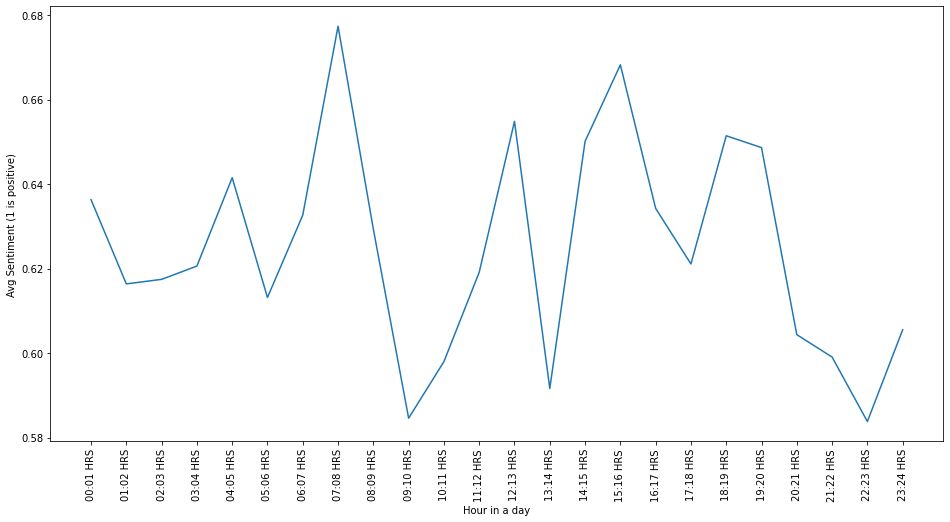

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.xticks(rotation = 90)
plt.plot([f'{str(i).zfill(2)}:{str(i+1).zfill(2)} HRS' for i in range(24)],stats.sentiment)
plt.xlabel('Hour in a day')
plt.ylabel('Avg Sentiment (1 is positive)')

In [0]:
len(us_tweets.place_full_name.unique())

1868

In [0]:
us_tweets.place_full_name.unique()

array(['Brooklyn, NY', 'Pawtucket, RI', 'Mercer Island, WA', ...,
       'Lantana, TX', 'Dayton, KY', 'Clinton, MD'], dtype=object)

Text(0, 0.5, 'Avg Sentiment (1 is positive)')

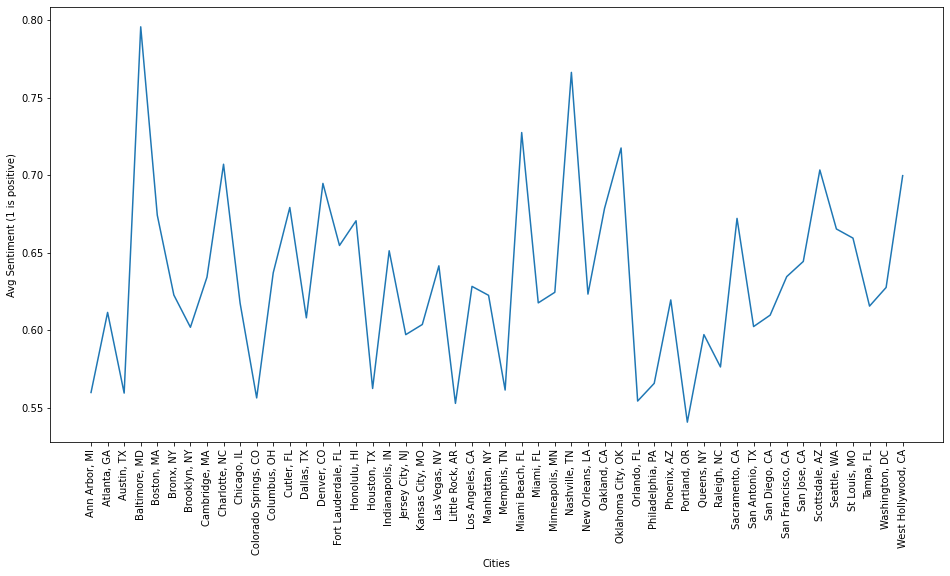

In [0]:
top50_cities = us_tweets[['place_full_name']].groupby(['place_full_name'])['place_full_name'].size().nlargest(50)
us_cities_sent = us_tweets[us_tweets.place_full_name.isin(top50_cities.keys())][['place_full_name','sentiment']]
us_cities_sent = us_cities_sent[['place_full_name','sentiment']].groupby('place_full_name').mean().reset_index()
# visualize where we will show sentiment and states
plt.figure(figsize=(16,8))
plt.xticks(rotation = 90)
plt.plot(us_cities_sent.place_full_name,us_cities_sent.sentiment)
plt.xlabel('Cities')
plt.ylabel('Avg Sentiment (1 is positive)')